# Training

## Setup

In [160]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [161]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True


# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Reverse the normalization to get values in [0, 1]
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2)  # Reverse the normalization to get values in [0, 1]
])


    

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

In [162]:

# Cosine noise schedule
def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return min(torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2), 0.999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([min(f(t)/f(torch.tensor([0])),0.999999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)


# # Linear noise schedule
# T = 1000
# beta_start, beta_end = 1e-4, 2e-2
# beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
# alpha = 1.0 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# # Reshape for broadcasting (if required for your model)
# alpha = alpha.view((T, 1, 1, 1)).to(device)
# beta = beta.view((T, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [163]:
import math
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32) * math.log(10000) / half_dim
        ).to(t.device)
        angles = t[:, None] * freqs[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [164]:
class LinearTimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(LinearTimeEmbedding, self).__init__()
        self.projection = nn.Linear(1, embedding_dim)  # Project the scalar to the embedding dimension

    def forward(self, t):
        return self.projection(t.unsqueeze(-1))  # Add an extra dimension for the projection


In [234]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.channels = [1,32, 64, 128, 256, 512]
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.GroupNorm(4, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(self.channels[2], self.channels[3], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(self.channels[3], self.channels[4], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=0),  # (batchsize, 256, 2, 2)
                nn.Conv2d(self.channels[4], self.channels[5], kernel_size=3, padding=1),  # (batchsize, 512, 2, 2)
                nn.GroupNorm(8, self.channels[5]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[5], self.channels[4], kernel_size=3,
                                      stride=2, padding=1, output_padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[4]*2, self.channels[3], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[3]*2, self.channels[2], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.GroupNorm(8, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[2]*2, self.channels[1], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.Conv2d(self.channels[1]*2, self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1),
                nn.Conv2d(self.channels[1], 1, kernel_size=1)  # (batchsize, 1, 28, 28)
            )      
        ])
        

    def forward(self, x, t_emb):
        signal = x
        signals = []
        t_emb_norm = F.normalize(t_emb, p=2, dim=-1)
        # Pass through the encoding layers
        for i, conv in enumerate(self.convs):
            lin_time = nn.Linear(128, self.channels[i],device=device) # 128 is the size of the time embedding.
            t_emb_processed = lin_time(t_emb_norm).view(-1, self.channels[i], 1, 1)
            signal= t_emb_processed+signal
            signal = conv(signal)
            if i < len(self.convs)-1:
                signals.append(signal)

        for i, tconv in enumerate(self.tconvs):
            # print(f"signal shape: {signal.shape}")
            # print(f"signals[-{i}] shape: {signals[-i].shape}")
            # print()
            lin_time = nn.Linear(128, self.channels[-i-1],device=device)
            t_emb_processed = lin_time(t_emb_norm).view(-1, self.channels[-i-1], 1, 1)
            signal= signal+t_emb_processed
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)

        return signal



## Training loop

In [216]:
#from UNET import UNET
epochs = 20
model = UNET().to(device)


In [227]:
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = torch.nn.MSELoss()

running_loss = 0
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)


In [228]:
# Training loop
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        t_emb = time_embedding_layer(t)  # Shape: [batch_size, embedding_dim]
        eps = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
        loss = criterion(predicted_eps, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if e % 100 == 99:
            print(f"Epoch {epoch}, Batch {e+1}, Average Loss: {running_loss / 100:.4f}")
            running_loss = 0.0  

    if epoch % 2 == 0:
        torch.save(model.state_dict(), f"DDPM_{epoch+1}.pth")




Epoch 0, Batch 100, Average Loss: 0.0783
Epoch 0, Batch 200, Average Loss: 0.0771
Epoch 0, Batch 300, Average Loss: 0.0761
Epoch 0, Batch 400, Average Loss: 0.0816
Epoch 0, Batch 500, Average Loss: 0.0769
Epoch 0, Batch 600, Average Loss: 0.0783
Epoch 0, Batch 700, Average Loss: 0.0843
Epoch 0, Batch 800, Average Loss: 0.0789
Epoch 0, Batch 900, Average Loss: 0.0798
Epoch 0, Batch 1000, Average Loss: 0.0788
Epoch 0, Batch 1100, Average Loss: 0.0748
Epoch 0, Batch 1200, Average Loss: 0.0770
Epoch 0, Batch 1300, Average Loss: 0.0760
Epoch 0, Batch 1400, Average Loss: 0.0795
Epoch 0, Batch 1500, Average Loss: 0.0798
Epoch 0, Batch 1600, Average Loss: 0.0764
Epoch 0, Batch 1700, Average Loss: 0.0816
Epoch 0, Batch 1800, Average Loss: 0.0732
Epoch 0, Batch 1900, Average Loss: 0.0749
Epoch 0, Batch 2000, Average Loss: 0.0792
Epoch 0, Batch 2100, Average Loss: 0.0735
Epoch 0, Batch 2200, Average Loss: 0.0777
Epoch 0, Batch 2300, Average Loss: 0.0760
Epoch 0, Batch 2400, Average Loss: 0.0742
E

KeyboardInterrupt: 

# Sampling

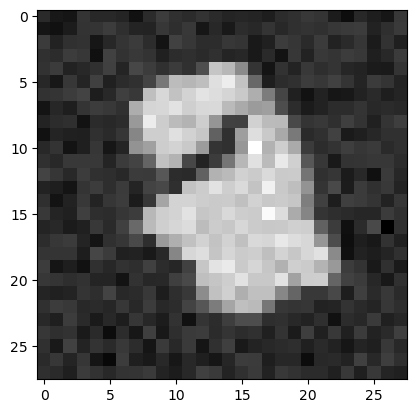

In [233]:
load_model = None
if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))

model.eval()

xt = torch.randn(1, 1, 28, 28).to(device)
with torch.inference_mode():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1)
        t = t.to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(1, 1, 28, 28).to(device) if t > 1 else torch.zeros(1, 1, 28, 28).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t])/(torch.sqrt(1 - alpha_bar[t])) * 
                                                    model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new


plt.imshow(reverse_transform(xt[0][0].cpu().detach()), cmap="grey")

# Overfit one batch

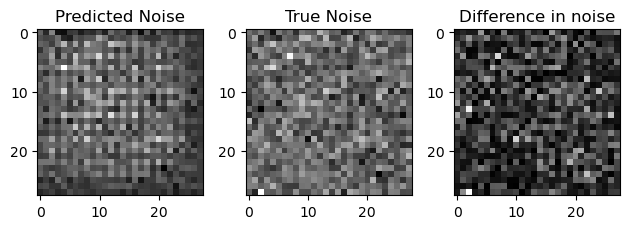

Epoch 99, Batch 847, Average Loss: 0.2245
Epoch 199, Batch 847, Average Loss: 0.0650
Epoch 299, Batch 847, Average Loss: 0.0518
Epoch 399, Batch 847, Average Loss: 0.0367


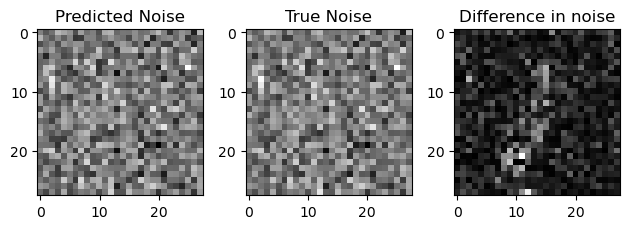

Epoch 499, Batch 847, Average Loss: 0.0339
Epoch 599, Batch 847, Average Loss: 0.0372
Epoch 699, Batch 847, Average Loss: 0.0306
Epoch 799, Batch 847, Average Loss: 0.0318


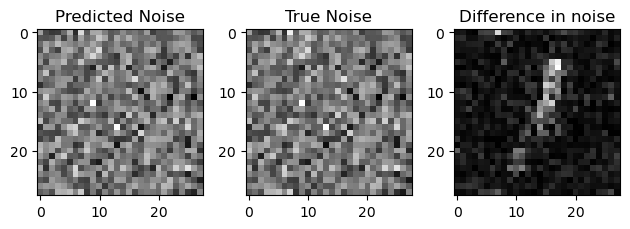

Epoch 899, Batch 847, Average Loss: 0.0315
Epoch 999, Batch 847, Average Loss: 0.0283
Epoch 1099, Batch 847, Average Loss: 0.0298
Epoch 1199, Batch 847, Average Loss: 0.0313


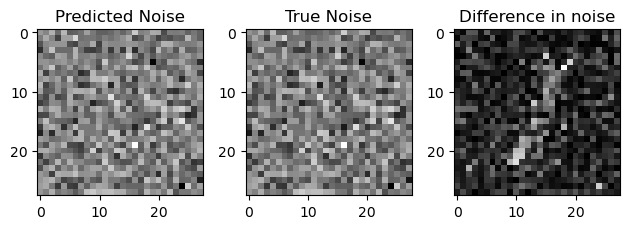

Epoch 1299, Batch 847, Average Loss: 0.0192
Epoch 1399, Batch 847, Average Loss: 0.0299
Epoch 1499, Batch 847, Average Loss: 0.0262
Epoch 1599, Batch 847, Average Loss: 0.0249


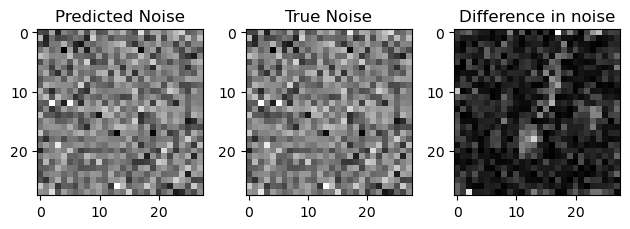

Epoch 1699, Batch 847, Average Loss: 0.0269
Epoch 1799, Batch 847, Average Loss: 0.0262
Epoch 1899, Batch 847, Average Loss: 0.0214
Epoch 1999, Batch 847, Average Loss: 0.0219


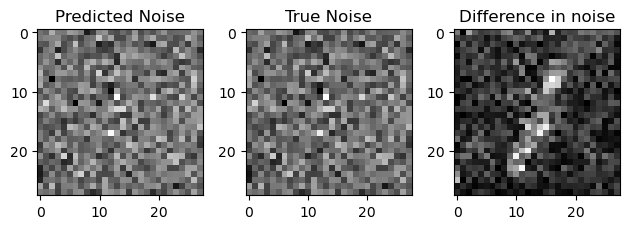

Epoch 2099, Batch 847, Average Loss: 0.0259
Epoch 2199, Batch 847, Average Loss: 0.0259
Epoch 2299, Batch 847, Average Loss: 0.0287
Epoch 2399, Batch 847, Average Loss: 0.0221


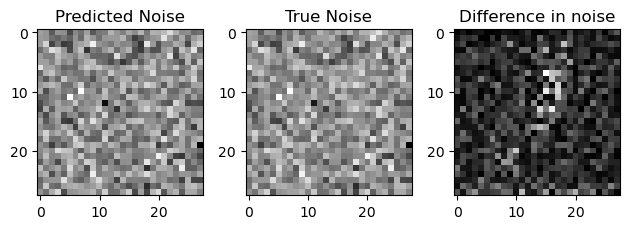

Epoch 2499, Batch 847, Average Loss: 0.0241
Epoch 2599, Batch 847, Average Loss: 0.0256
Epoch 2699, Batch 847, Average Loss: 0.0266
Epoch 2799, Batch 847, Average Loss: 0.0218


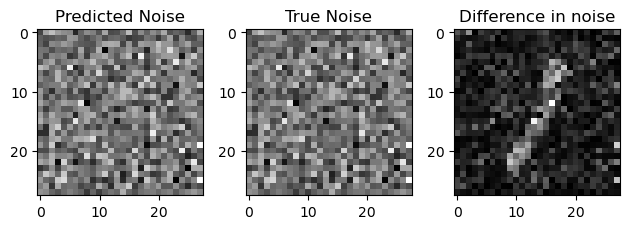

Epoch 2899, Batch 847, Average Loss: 0.0252
Epoch 2999, Batch 847, Average Loss: 0.0219
Epoch 3099, Batch 847, Average Loss: 0.0272
Epoch 3199, Batch 847, Average Loss: 0.0231


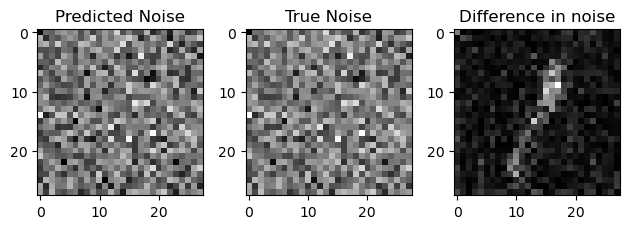

Epoch 3299, Batch 847, Average Loss: 0.0247
Epoch 3399, Batch 847, Average Loss: 0.0241
Epoch 3499, Batch 847, Average Loss: 0.0210
Epoch 3599, Batch 847, Average Loss: 0.0205


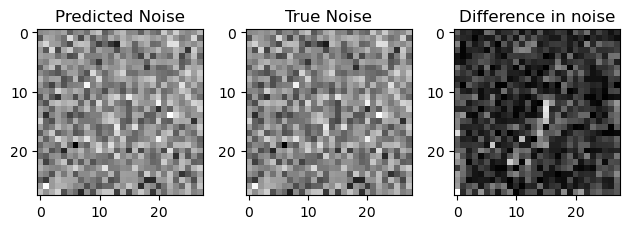

Epoch 3699, Batch 847, Average Loss: 0.0235
Epoch 3799, Batch 847, Average Loss: 0.0178
Epoch 3899, Batch 847, Average Loss: 0.0222
Epoch 3999, Batch 847, Average Loss: 0.0220


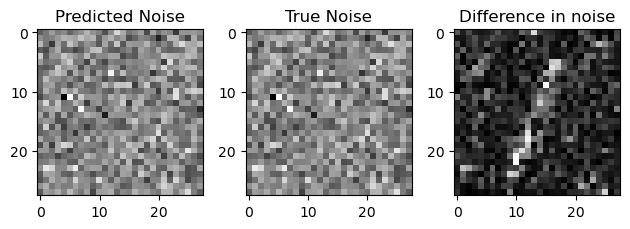

Epoch 4099, Batch 847, Average Loss: 0.0223
Epoch 4199, Batch 847, Average Loss: 0.0224
Epoch 4299, Batch 847, Average Loss: 0.0242
Epoch 4399, Batch 847, Average Loss: 0.0269


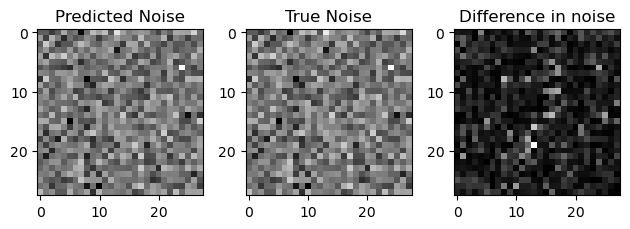

Epoch 4499, Batch 847, Average Loss: 0.0156
Epoch 4599, Batch 847, Average Loss: 0.0192
Epoch 4699, Batch 847, Average Loss: 0.0206
Epoch 4799, Batch 847, Average Loss: 0.0292


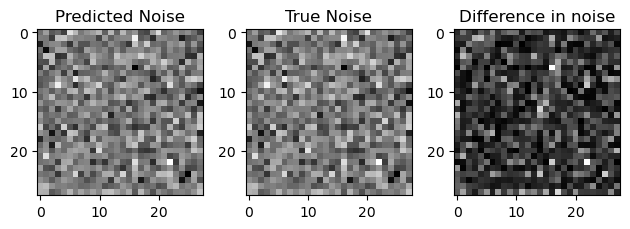

Epoch 4899, Batch 847, Average Loss: 0.0224
Epoch 4999, Batch 847, Average Loss: 0.0248


In [221]:
#from UNET import UNET

model = UNET().to(device)
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

# Get a single image from the batch
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(batch_size, 1, 1, 1)
# Set the model to training mode
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
plot_every = 400

running_loss = 0
# Training loop to overfit one batch
epochs = 5000
for epoch in range(epochs):
    t = torch.randint(0, T, (batch_size,), device=device)
    t_emb = time_embedding_layer(t)  # Shape: [batch_size, embedding_dim]
    eps = torch.randn_like(single_batchs).to(device)
    x_t = torch.sqrt(alpha_bar[t]) * single_batchs + torch.sqrt(1 - alpha_bar[t]) * eps
    predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
    loss = criterion(predicted_eps, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if epoch % 100 == 99:
        print(f"Epoch {epoch}, Batch {e+1}, Average Loss: {running_loss / 100:.4f}")
        running_loss = 0.0  

    if epoch % plot_every == 0:
        with torch.inference_mode():
            model.eval()
            t = torch.randint(0, T, (1,), device=device)
            t_emb = time_embedding_layer(t)
            eps = torch.randn_like(single_batch).to(device)
            x_t = torch.sqrt(alpha_bar[t]) * single_batch + torch.sqrt(1 - alpha_bar[t]) * eps
            predicted_eps = model(x_t, t_emb)
            reconstructed = x_t - predicted_eps
            fig, axs = plt.subplots(1, 3, tight_layout=True)
            axs[0].imshow(predicted_eps[0][0].cpu().detach().numpy(), cmap="gray")
            axs[0].set_title("Predicted Noise")
            axs[1].imshow(eps[0][0].cpu().detach().numpy(), cmap="gray")
            axs[1].set_title("True Noise")
            axs[2].imshow(np.abs(predicted_eps[0][0].cpu().detach().numpy()-eps[0][0].cpu().detach().numpy()), cmap="gray")
            axs[2].set_title("Difference in noise")
            plt.show()

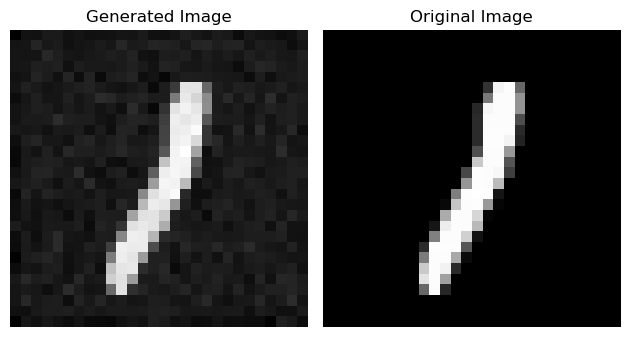

In [224]:
# Set the model to evaluation mode
model.eval()

# Initialize a random noise tensor
xt = torch.randn(1, 1, 28, 28).to(device)

# Perform the reverse diffusion process
with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(1, 1, 28, 28).to(device) if t > 1 else torch.zeros(1, 1, 28, 28).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new

# Plot the generated image
fig,axs = plt.subplots(1, 2, tight_layout=True)
axs[0].imshow(reverse_transform(xt[0][0].cpu().detach().numpy()), cmap="gray")
axs[0].set_title("Generated Image")
axs[0].axis("off")
axs[1].imshow(reverse_transform(single_batch[0][0].cpu().detach().numpy()), cmap="gray")
axs[1].set_title("Original Image")
axs[1].axis("off")
plt.show()